2025-07-10 11:44:39 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-07-10 11:44:39 INFO     xscen.config    Updated the config with ../config_obs.yml.


Processing variable: pr_mean_seasonal_rmse_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/tmp/ipykernel_2623549/704487157.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


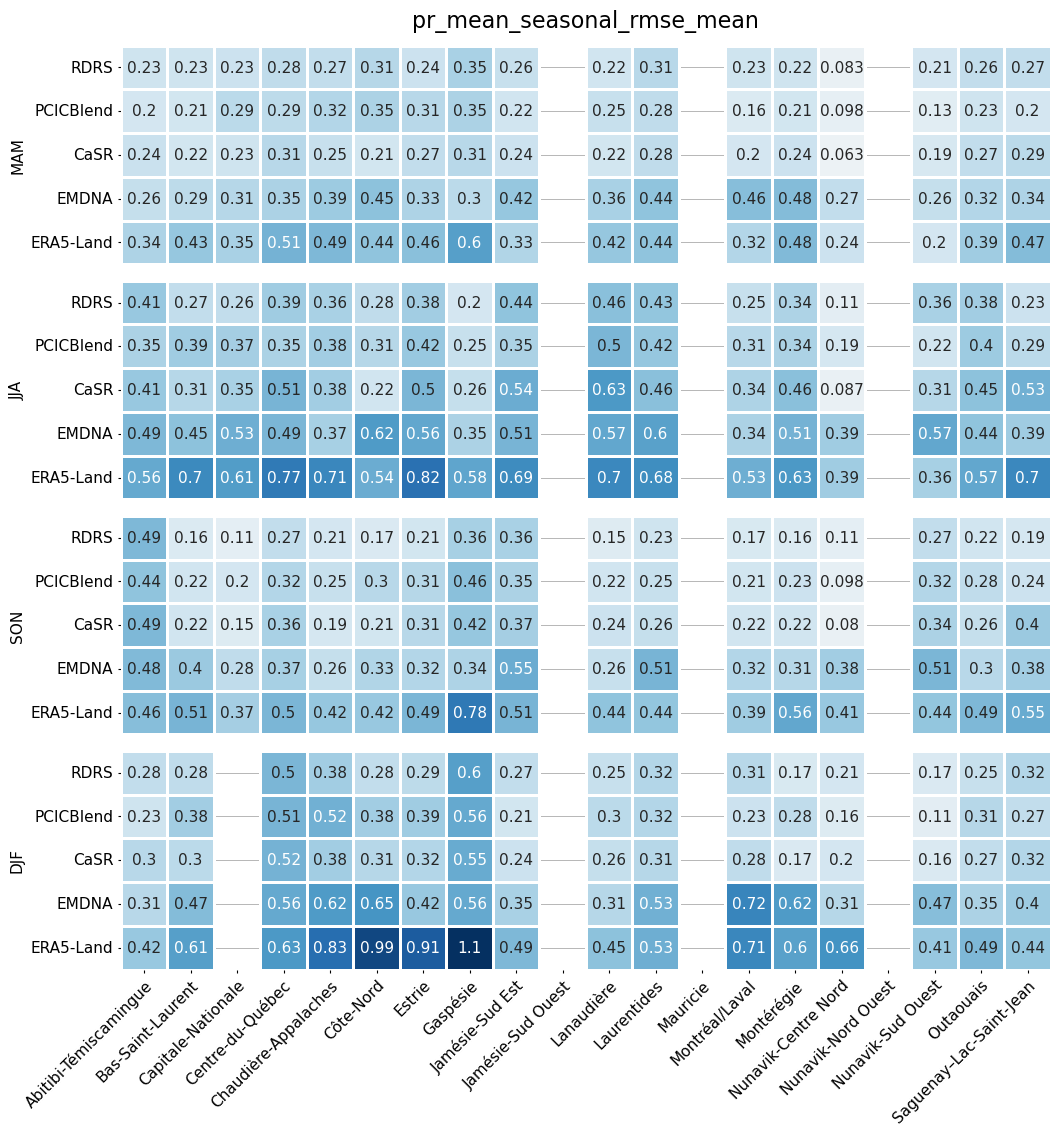

Processing variable: tg_mean_annual_rmse_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/tmp/ipykernel_2623549/704487157.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


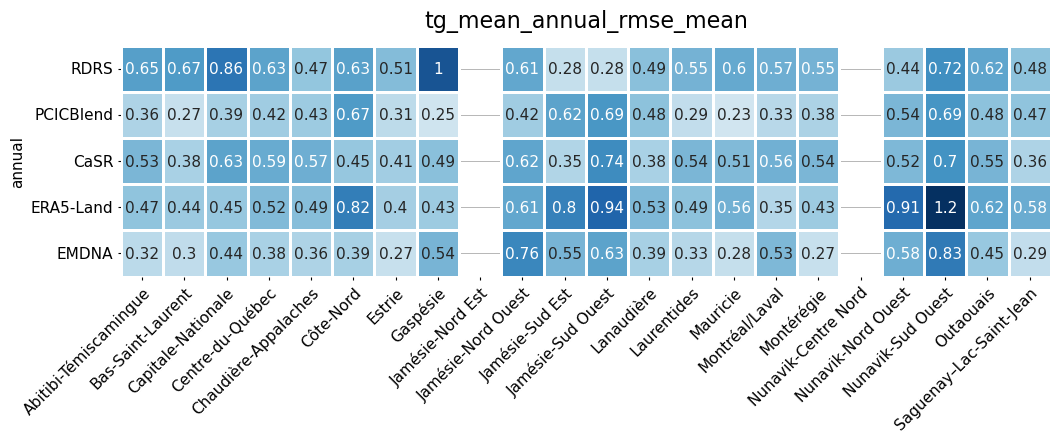

Processing variable: pr_mean_annual_rmse_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/tmp/ipykernel_2623549/704487157.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


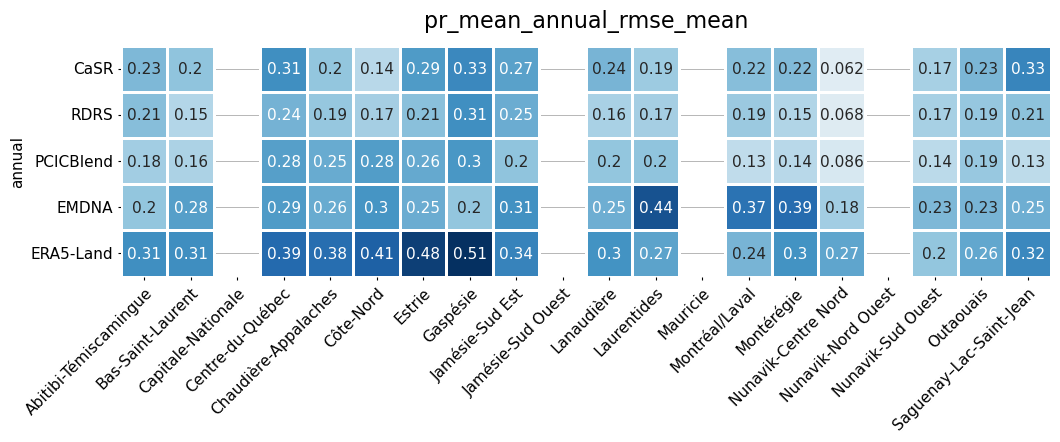

Processing variable: tg_mean_seasonal_rmse_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/tmp/ipykernel_2623549/704487157.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


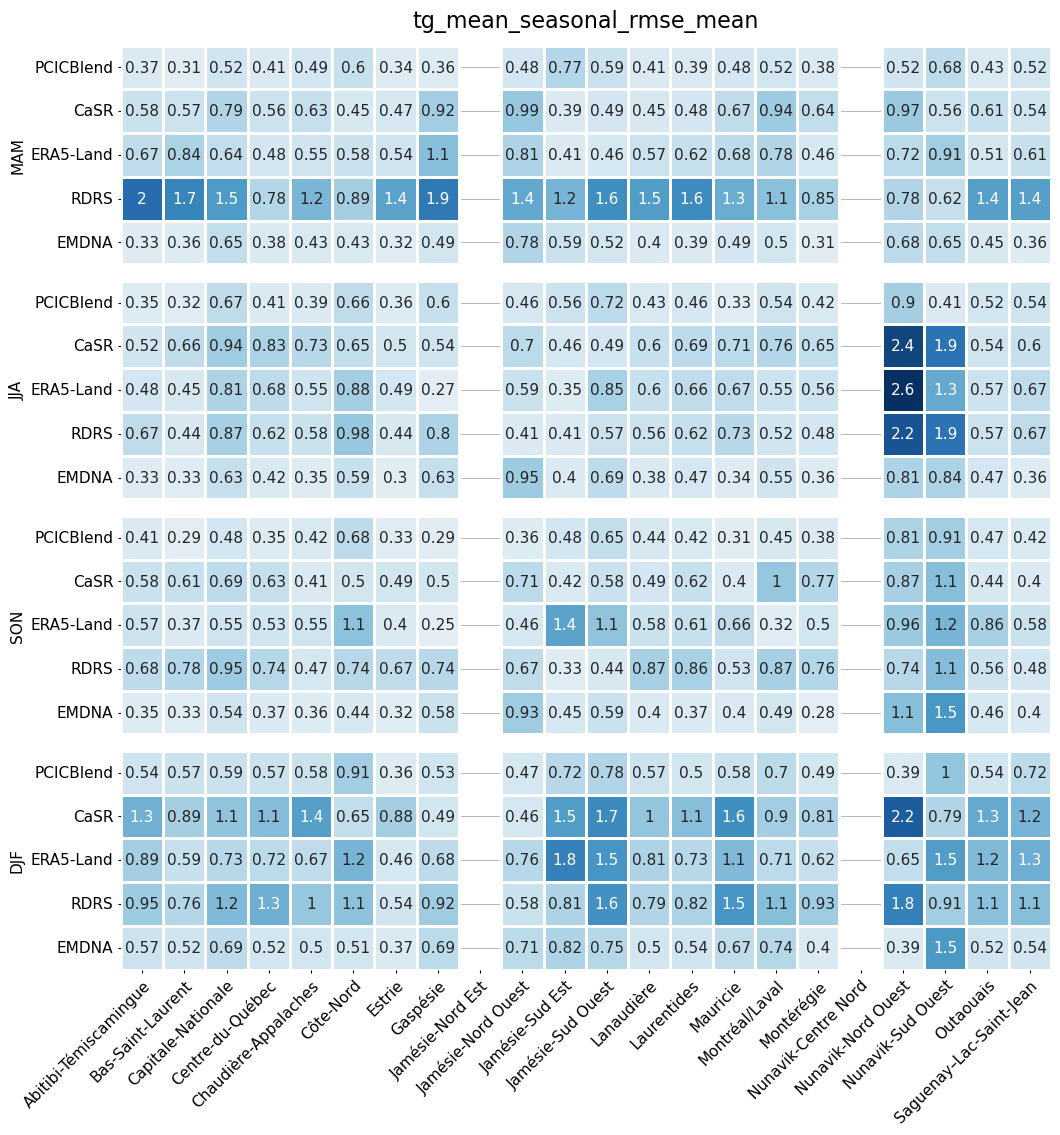

In [27]:
import xscen as xs
from xscen.config import CONFIG
import figanos.matplotlib as fg

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fg.utils.set_mpl_style('ouranos')

# === Load configuration ===
xs.load_config(
    "../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True
)

pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])
pcat_df = pcat.df

# === MAIN LOOP ===
pcat_df_spatial = pcat_df[pcat_df["processing_level"] == "spatial_mean"]
variable_groups = pcat_df_spatial["variable"].unique()
variables = set(item for group in variable_groups for item in group)

for spatial_var in variables:
    print(f"Processing variable: {spatial_var}")

    # Load spatial_mean dataset for this variable
    dts = pcat.search(processing_level="spatial_mean", variable=spatial_var).to_dataset_dict()

    if not dts:
        print(f"No spatial_mean datasets found for variable {spatial_var}")
        continue

    # Should normally be only one dataset for this variable / processing_level
    ds = list(dts.values())[0]

    seasons = ds["season"].values
    n_seasons = len(seasons)

    # === Setup figure layout ===
    fig = plt.figure(figsize=(12, 3 * n_seasons), constrained_layout=False)

    gs = gridspec.GridSpec(nrows=n_seasons, ncols=1, figure=fig, wspace=0.0, hspace=0.075)

    axs = []
    for i in range(n_seasons):
        axs.append(fig.add_subplot(gs[i, 0]))

    # === Compute color scale across all seasons ===
    vmin = float(ds[spatial_var].min().values)
    vmax = float(ds[spatial_var].max().values)

    # === Plot heatmap for each season ===
    for i, season in enumerate(seasons):
        ax = axs[i]

        da = ds[spatial_var].sel(season=season)

        fg.heatmap(
            da,
            ax=ax,
            divergent=None,
            plot_kw={"vmin": vmin, "vmax": vmax, "linecolor": "w", "linewidth": 1.0, "annot": True, "cbar":False},
        )

        ax.set_title(str(season), fontsize=12)

        # Remove x-axis tick labels for all but the bottom plot
        if i != n_seasons - 1:
            ax.set_xticks([])
        ax.set_xlabel("")
        ax.set_ylabel(season)
        if i == 0:
            ax.set_title(f"{spatial_var}", fontsize=16, y=1.02)
        else:
            ax.set_title("")

    plt.tight_layout()
    #plt.savefig(f"{spatial_var}.png",dpi=400, bbox_inches="tight")
    plt.show()


## Finding the best sources (smallest RMSE) by region

In [28]:
import xscen as xs
from xscen.config import CONFIG
import figanos.matplotlib as fg

import pandas as pd
import numpy as np

# === Load config ===
fg.utils.set_mpl_style('ouranos')
xs.load_config(
    "../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True
)

pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])
pcat_df = pcat.df

# === Source color mapping ===
SOURCE_COLORS = {
    "EMDNA": "#FFD580",   # soft orange
    "PCICBlend": "#B6E2B6",  # soft green
    "RDRS": "#ADD8E6",    # soft blue
    "ERA5-Land": "#E6B6E2",  # soft magenta
    "CaSR": "#F4A6A6"     # soft red
}

# === Get sorted list of variables ===
pcat_df_spatial = pcat_df[pcat_df["processing_level"] == "spatial_mean"]
variable_groups = pcat_df_spatial["variable"].unique()
variables = sorted(set(item for group in variable_groups for item in group))

# === Union of all regions ===
all_regions = set()
for spatial_var in variables:
    dts = pcat.search(processing_level="spatial_mean", variable=spatial_var).to_dataset_dict()
    if not dts:
        continue
    ds = list(dts.values())[0]
    all_regions.update(ds["region"].values)
all_regions = sorted(all_regions)

# === Build data and source tables ===
data_cells = {}
source_cells = {}

for spatial_var in variables:
    print(f"Processing variable: {spatial_var}")

    dts = pcat.search(processing_level="spatial_mean", variable=spatial_var).to_dataset_dict()

    if not dts:
        print(f"No spatial_mean datasets found for variable {spatial_var}")
        continue

    ds = list(dts.values())[0]
    seasons = ds["season"].values

    best_source = ds[spatial_var].idxmin(dim="source")
    best_rmse = ds[spatial_var].min(dim="source")

    for season in seasons:
        rmse_values = best_rmse.sel(season=season).values
        sources = best_source.sel(season=season).values
        regions = ds["region"].values

        # Create two series: one for values, one for sources
        rmse_series = pd.Series(
            {region: f"{val:.2f}" if pd.notna(val) else "NaN"
             for region, val in zip(regions, rmse_values)}
        ).reindex(all_regions, fill_value=np.nan)

        source_series = pd.Series(
            {region: src if pd.notna(val) and src is not None else np.nan
             for region, val, src in zip(regions, rmse_values, sources)}
        ).reindex(all_regions, fill_value=np.nan)

        # Store
        data_cells[(spatial_var, str(season))] = rmse_series
        source_cells[(spatial_var, str(season))] = source_series

# === Create MultiIndex DataFrames ===
columns = pd.MultiIndex.from_tuples(data_cells.keys(), names=["Variable", "Season"])
df_values = pd.DataFrame(data_cells, index=all_regions, columns=columns)
df_sources = pd.DataFrame(source_cells, index=all_regions, columns=columns)
df_values.index.name = "Region"

# === Replace NaNs in the values DataFrame with empty strings (for black cells) ===
df_values = df_values.fillna("")

# === Build thicker borders between variables ===
column_borders = pd.DataFrame("", index=df_values.index, columns=df_values.columns)
last_var = None
for col in df_values.columns:
    var = col[0]
    if var != last_var and last_var is not None:
        # New variable → add left border
        column_borders[col] = "border-left: 3px solid black;"
    last_var = var

# === Build full CSS styles for each cell ===
style_data = pd.DataFrame(index=df_values.index, columns=df_values.columns)

for col in df_values.columns:
    for idx in df_values.index:
        val = df_values.at[idx, col]
        src = df_sources.at[idx, col]

        if val == "":
            cell_style = "background-color: black; color: white; text-align: center"
        elif val == "NaN":
            cell_style = "background-color: white; color: black; text-align: center"
        else:
            color = SOURCE_COLORS.get(src, "white")
            cell_style = f"background-color: {color}; color: black; text-align: center"

        border_style = column_borders.at[idx, col]
        style_data.at[idx, col] = f"{cell_style} {border_style}"

# === Apply styles to the table ===
styled = (
    df_values.style
    .apply(lambda _: style_data, axis=None)
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "td", "props": [("border", "1px solid #999")]},
        {"selector": "th", "props": [("border", "1px solid #666"), ("text-align", "center")]}
    ])
)

# Save main table
styled.to_html("./outputs/rmse_table.html")

# === Create legend table ===
legend_df = pd.DataFrame({
    "Source": list(SOURCE_COLORS.keys()),
    "Color": [""] * len(SOURCE_COLORS)  # Keep cells empty
})

# Apply background colors based on the Source column
legend_styler = legend_df.style.applymap(
    lambda _: "", subset=["Color"]  # No text content
).apply(
    lambda col: [
        f"background-color: {SOURCE_COLORS.get(source, 'white')}; text-align: center"
        for source in legend_df["Source"]
    ] if col.name == "Color" else [""] * len(col),
    axis=0
).set_properties(**{"text-align": "center"}).set_table_styles(
    [{"selector": "th", "props": [("text-align", "center")]}]
)

# Save legend table
legend_styler.to_html("./outputs/rmse_legend.html")

# === Display in notebook ===
import IPython.display as display
display.display(styled)
display.display(legend_styler)

print("Tables generated successfully.")


2025-07-10 11:44:42 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-07-10 11:44:42 INFO     xscen.config    Updated the config with ../config_obs.yml.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


Processing variable: pr_mean_annual_rmse_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


Processing variable: pr_mean_seasonal_rmse_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


Processing variable: tg_mean_annual_rmse_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


Processing variable: tg_mean_seasonal_rmse_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/tmp/ipykernel_2623549/3725002937.py:139: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.


,Source,Color
0,EMDNA,
1,PCICBlend,
2,RDRS,
3,ERA5-Land,
4,CaSR,


Tables generated successfully.


#### Regions that are not present in the dataset for a given variable (but exist for other variables) are shown as black cells. Regions where the data exists but is insufficient for computation are shown as white cells containing 'NaN'. Regions with no data for any variable are omitted from the table.